# Automatically generating object masks with SAM

This notebook is a Keras Core port of the mask generator example on facebook/segment-anything.

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SAMAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [1]:
%%capture
pip install git+https://github.com/facebookresearch/segment-anything.git

In [2]:
%%capture
pip install -U keras-core keras-cv

In [3]:
%%capture
pip install git+https://github.com/tirthasheshpatel/segment_anything_keras.git

In [4]:
# Get the image for the demo
!curl -sSL https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg -o dog.jpg

In [5]:
# Get the huge PyTorch model weights
!curl -sSL https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -o sam_vit_h_4b8939.pth

In [6]:
import os

os.environ['KERAS_CV_MULTI_BACKEND'] = "1"
os.environ['KERAS_BACKEND'] = "tensorflow"
os.environ['JAX_ENABLE_X64'] = "1"

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# torch model
import torch
from segment_anything.build_sam import build_sam_vit_h
from segment_anything.modeling import Sam
from segment_anything import sam_model_registry, SamPredictor

# keras model
import keras_core as keras
from keras_core.src import ops
from sam_keras import ImageEncoder
from sam_keras import PromptEncoder
from sam_keras import MaskDecoder, TwoWayTransformer
from sam_keras import SegmentAnythingModel
from sam_keras import SAMAutomaticMaskGenerator
from sam_keras import port_weights

Using TensorFlow backend


In [8]:
# Define the huge model in TensorFlow

image_encoder = ImageEncoder(
    img_size=1024,
    patch_size=16,
    in_chans=3,
    embed_dim=1280,
    depth=32,
    mlp_dim=1280*4,
    num_heads=16,
    out_chans=256,
    use_bias=True,
    use_rel_pos=True,
    window_size=14,
    global_attention_indices=[7, 15, 23, 31]
)

prompt_encoder = PromptEncoder(
    embed_dim=256,
    image_embedding_size=(64, 64),
    input_image_size=(1024, 1024),
    mask_in_chans=16
)

mask_decoder = MaskDecoder(
    transformer_dim=256,
    transformer=TwoWayTransformer(
        depth=2,
        embedding_dim=256,
        mlp_dim=2048,
        num_heads=8
    ),
    num_multimask_outputs=3,
    iou_head_depth=3,
    iou_head_hidden_dim=256
)

In [9]:
model = SegmentAnythingModel(image_encoder, prompt_encoder, mask_decoder)

In [10]:
# We create a predictor to port the weights from PyTorch to TensorFlow

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to("cuda")

predictor = SamPredictor(sam)

In [11]:
# Port the PyTorch model's weights to the multi-backend Keras model
port_weights(model, predictor.model)

In [12]:
image = cv2.imread('dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

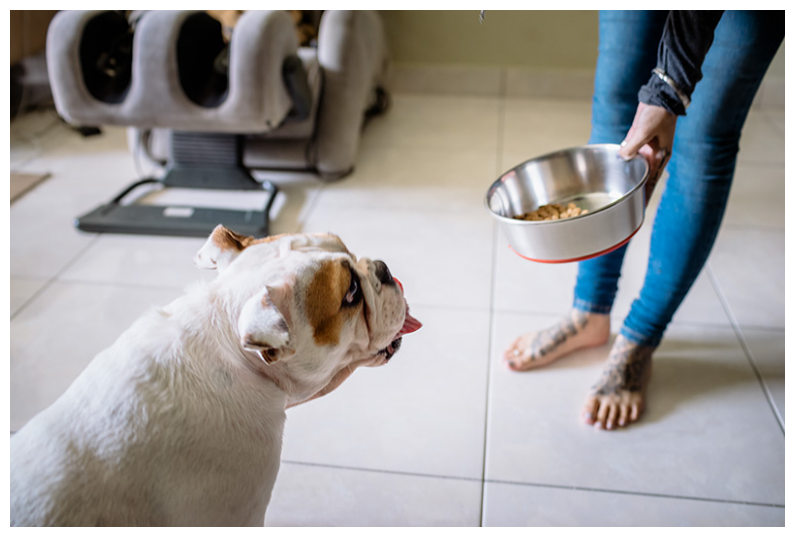

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation


To run automatic mask generation, provide a SAM model to the `SAMAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint.

In [14]:
mask_generator = SAMAutomaticMaskGenerator(model)

In [15]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- `segmentation` : the mask
- `area` : the area of the mask in pixels
- `bbox` : the boundary box of the mask in XYWH format
- `predicted_iou` : the model's own prediction for the quality of the mask
- `point_coords` : the sampled input point that generated this mask
- `stability_score` : an additional measure of mask quality
- `crop_box` : the crop of the image used to generate this mask in XYWH format

In [16]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [17]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

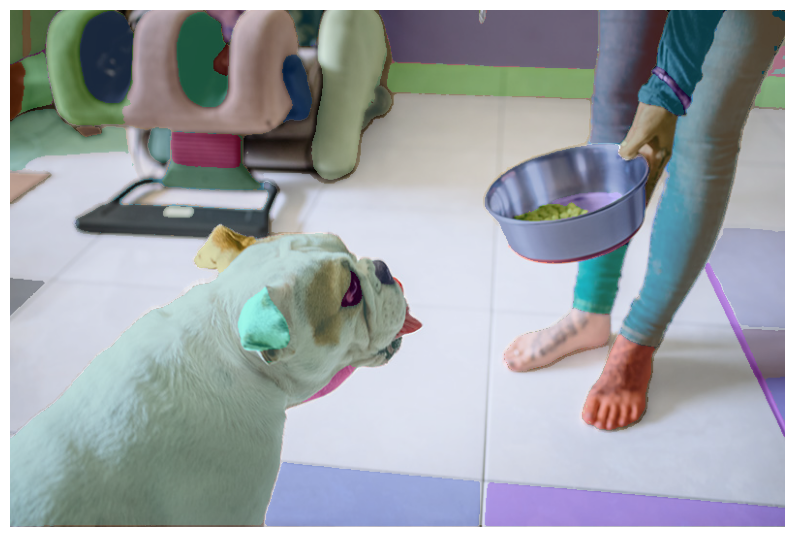

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options


There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [19]:
mask_generator_2 = SAMAutomaticMaskGenerator(
    model=model,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [20]:
masks2 = mask_generator_2.generate(image)

In [21]:
len(masks2)

89

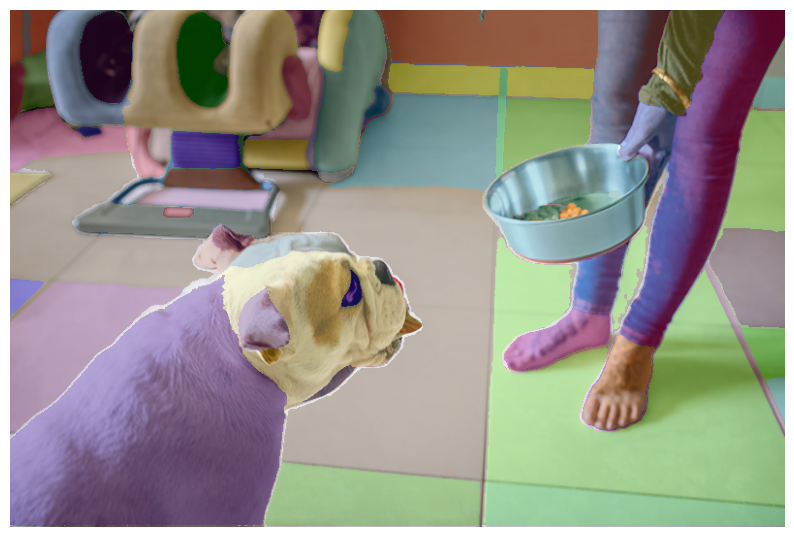

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()